In [1]:
import torch
import matplotlib.pyplot as plt
from context import *

## 1D Toy Examples

### Learn from Data

In [2]:
mdl = RGModel([1], 1, 1, hdims=[16, 8], hyper_dim=16)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)

In [3]:
x_dat = torch.tensor([-1.]*50+[1.]*50)
x_dat = x_dat + 0.1*torch.randn_like(x_dat)
x_dat = x_dat[:,None,None]
x_dat.shape

torch.Size([100, 1, 1])

In [26]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.nll_loss(x_dat, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

 0.09  0.04  0.52  4.62
-0.09 -0.15  0.55  5.57
-0.10 -0.17  0.67  5.72
-0.02 -0.08  0.83  5.53
 0.35  0.29  0.91  4.99
 0.41  0.36  0.71  4.46
-0.22 -0.28  0.51  5.27
-0.12 -0.17  0.49  4.56
-0.21 -0.27  0.48  5.38
 0.32  0.28  0.53  3.35


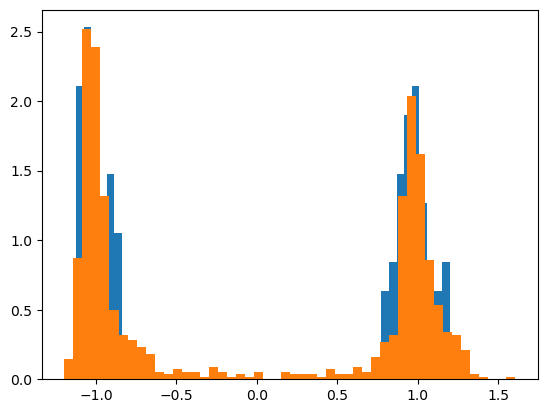

In [27]:
mdl.eval()
x_smp = mdl.rsample(1000)
plt.hist(x_dat.squeeze().tolist(), bins=50, density=True);
plt.hist(x_smp.squeeze().tolist(), bins=50, density=True);

### Learn from Energy

In [2]:
mdl = RGModel([1], 1, 1, hdims=[16, 8], hyper_dim=16)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)

In [3]:
def energy(x):
    return torch.squeeze((x-1)**2/(2*(1/3)**2))

In [17]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.free_loss(energy, 1000, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

 1.64  1.60  1.96  1.50
 1.69  1.65  2.09  1.51
 1.66  1.62  1.91  1.42
 1.70  1.67  1.96  1.50
 1.64  1.60  2.00  1.44
 1.57  1.54  1.94  1.42
 1.65  1.62  2.05  1.43
 1.61  1.58  2.16  1.41
 1.60  1.57  1.98  1.46
 1.69  1.66  1.93  1.54


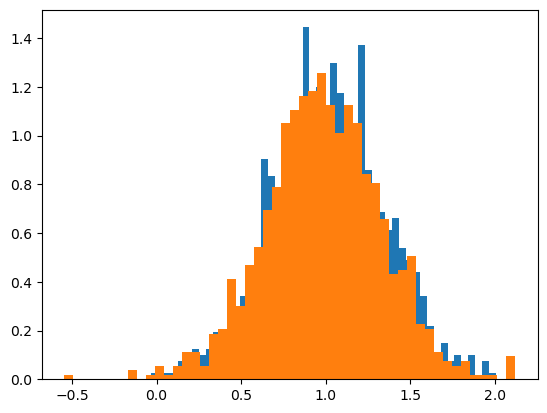

In [18]:
mdl.eval()
x_smp = mdl.rsample(1000)
x_dat = torch.randn_like(x_smp)/3+1
plt.hist(x_dat.squeeze().tolist(), bins=50, density=True);
plt.hist(x_smp.squeeze().tolist(), bins=50, density=True);

## MNIST

Get the MNIST dataset and randomly sample images from it.

In [14]:
from torchvision import datasets, transforms

# Define a transform to convert the images to PyTorch tensors
transform = transforms.ToTensor()

# Create a PyTorch MNIST dataset with the transform and download=True to download the dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a custom DataLoader object to load the images without labels
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Sample from the DataLoader to get a batch of images
images = next(iter(dataloader))[0]

# Print the shape of the batch of images
print(images.shape)  # Output: torch.Size([64, 1, 28, 28])

torch.Size([64, 1, 28, 28])


Visualize the sampled images.

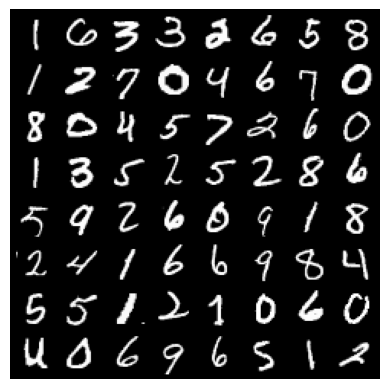

In [3]:
import matplotlib.pyplot as plt
import torchvision.utils

# Create a grid of images from the tensor
grid = torchvision.utils.make_grid(images, nrow=8)

# Transpose the grid to convert it from CHW to HWC format for matplotlib
grid = grid.permute(1, 2, 0)

# Display the grid of images using matplotlib
plt.imshow(grid)
plt.axis('off')
plt.show()

Build a RG flow-based generative model

In [53]:
# Create a RG flow-based generative model
model = RGModel([28, 28], 1, 3, hdims=[16, 16], hyper_dim=8)

# Set up an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [65]:
model.train()
optimizer.param_groups[0]['lr'] = 0.0001
for _ in range(10):
    optimizer.zero_grad()
    images = next(iter(dataloader))[0]
    out = model.nll_loss(images, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    optimizer.step()
    print(*[f'{o.item():5.2f}' for o in out])

-1179.86 -1333.88 2336.97 13065.75
-1144.25 -1296.45 2371.70 12848.48
-1142.12 -1294.44 2368.49 12864.17
-1174.28 -1327.54 2345.98 12980.18
-1205.87 -1360.00 2296.05 13116.74
-1162.31 -1314.98 2322.43 12944.61
-1161.12 -1313.08 2282.46 12913.84
-1162.39 -1314.43 2277.38 12926.70
-1212.76 -1367.30 2275.82 13177.84
-1177.02 -1330.78 2279.72 13096.43


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


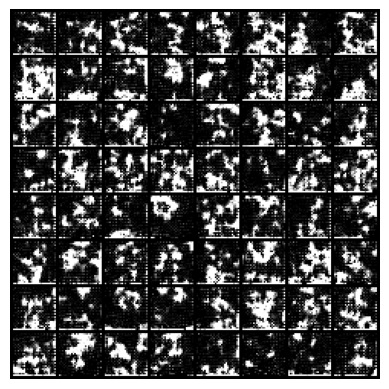

In [66]:
model.eval()
images = model.sample(64)

# Create a grid of images from the tensor
grid = torchvision.utils.make_grid(images, nrow=8)

# Transpose the grid to convert it from CHW to HWC format for matplotlib
grid = grid.permute(1, 2, 0)

# Display the grid of images using matplotlib
plt.imshow(grid)
plt.axis('off')
plt.show()

In [59]:
images

tensor(-7.1321)

In [43]:
torch.save(model.state_dict(), 'model.pt')

In [67]:
model.load_state_dict(torch.load('model_[16,16]_8.pt'))

<All keys matched successfully>